선택된 이미지: /home/byounggun/ultralytics/traffic_train/wide/images/t1_157.jpg
Initializing SiameseYOLOv8s with weights: yolov8s.pt
Successfully extracted backbone and head from yolov8s.pt. NC=80, reg_max=16
[Siamese] Detected backbone output channels: 512


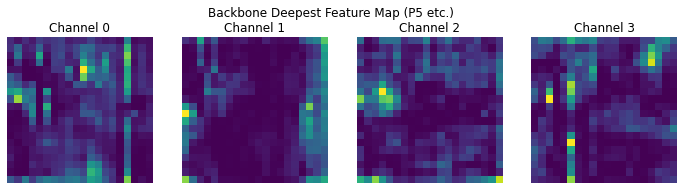

In [11]:
import os
import random
import torch
import matplotlib.pyplot as plt

# 이미지 폴더 경로
image_dir = "/home/byounggun/ultralytics/traffic_train/wide/images"

# 폴더 내 jpg/png 이미지 리스트업
img_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
assert len(img_files) > 0, "폴더에 이미지가 없습니다."

# 랜덤 이미지 선택
image_path = os.path.join(image_dir, random.choice(img_files))
print(f"선택된 이미지: {image_path}")

# 이미지 로드 및 전처리 함수 (예시, 실제 함수와 맞게 수정)
from PIL import Image
import numpy as np

def load_and_preprocess_image(image_path, img_size=640):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((img_size, img_size))
    img = np.array(img).astype(np.float32) / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)  # (1, 3, H, W)
    return img

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_tensor = load_and_preprocess_image(image_path, img_size=640).to(device)

# YOLOv8 백본 모델 (SiameseYOLOv8s) 불러오기
from yolov8_siamese import SiameseYOLOv8s
model = SiameseYOLOv8s(yolo_weights_path='yolov8s.pt').to(device)
model.eval()

# Backbone feature 추출
with torch.no_grad():
    features = model.extract_backbone_features(img_tensor)
    feat = features[-1]  # (1, C, H, W)
    feat = feat.squeeze(0).cpu()  # (C, H, W)

# Feature map 시각화 (앞의 4개 채널만 예시로 출력)
num_channels = min(4, feat.shape[0])
plt.figure(figsize=(12, 3))
for i in range(num_channels):
    plt.subplot(1, num_channels, i+1)
    plt.imshow(feat[i], cmap='viridis')
    plt.title(f"Channel {i}")
    plt.axis('off')
plt.suptitle("Backbone Deepest Feature Map (P5 etc.)")
plt.show()

선택된 파일: t2_266.jpg
Initializing SiameseYOLOv8s with weights: yolov8s.pt
Successfully extracted backbone and head from yolov8s.pt. NC=80, reg_max=16
[Siamese] Detected backbone output channels: 512


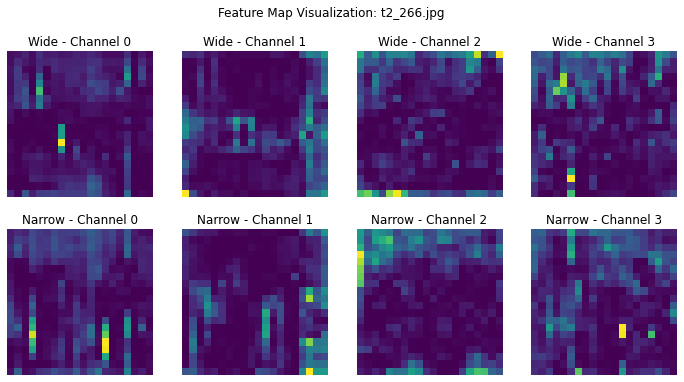

In [15]:
import os
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 이미지 폴더 경로
wide_dir = "/home/byounggun/ultralytics/traffic_train/wide/images"
narrow_dir = "/home/byounggun/ultralytics/traffic_train/narrow/images"

# 두 폴더에 모두 존재하는 파일명 리스트업
wide_files = set([f for f in os.listdir(wide_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
narrow_files = set([f for f in os.listdir(narrow_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
common_files = list(wide_files & narrow_files)
assert len(common_files) > 0, "두 폴더에 공통된 이미지 파일이 없습니다."

# 랜덤 선택
filename = random.choice(common_files)
wide_path = os.path.join(wide_dir, filename)
narrow_path = os.path.join(narrow_dir, filename)
print(f"선택된 파일: {filename}")

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(image_path, img_size=640):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((img_size, img_size))
    img = np.array(img).astype(np.float32) / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)  # (1, 3, H, W)
    return img

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_wide = load_and_preprocess_image(wide_path, img_size=640).to(device)
img_narrow = load_and_preprocess_image(narrow_path, img_size=640).to(device)

# YOLOv8 백본 모델 (SiameseYOLOv8s) 불러오기
from yolov8_siamese import SiameseYOLOv8s
model = SiameseYOLOv8s(yolo_weights_path='yolov8s.pt').to(device)
model.eval()

# Backbone feature 추출
with torch.no_grad():
    feat_wide = model.extract_backbone_features(img_wide)[-1].squeeze(0).cpu()    # (C, H, W)
    feat_narrow = model.extract_backbone_features(img_narrow)[-1].squeeze(0).cpu()# (C, H, W)

# Feature map 시각화 (앞의 4개 채널만 예시)
num_channels = min(4, feat_wide.shape[0], feat_narrow.shape[0])
plt.figure(figsize=(12, 6))
for i in range(num_channels):
    plt.subplot(2, num_channels, i+1)
    plt.imshow(feat_wide[i], cmap='viridis')
    plt.title(f"Wide - Channel {i}")
    plt.axis('off')
    plt.subplot(2, num_channels, num_channels+i+1)
    plt.imshow(feat_narrow[i], cmap='viridis')
    plt.title(f"Narrow - Channel {i}")
    plt.axis('off')
plt.suptitle(f"Feature Map Visualization: {filename}")
plt.show()

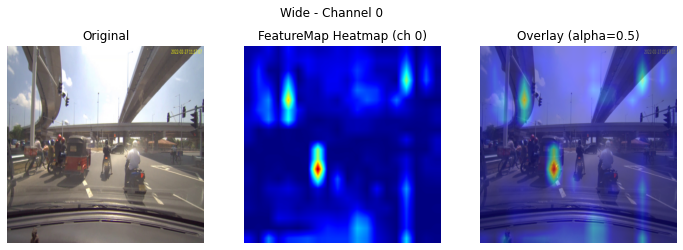

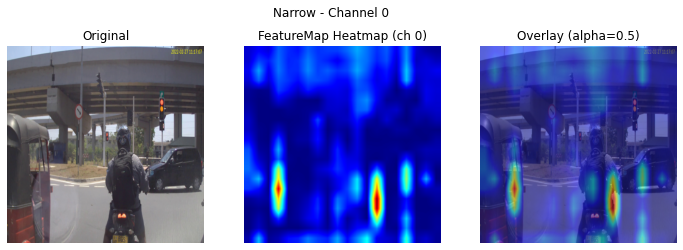

In [17]:
import cv2

def show_feature_overlay(orig_img_path, feature_map, channel=0, alpha=0.5, img_size=640, title=""):
    """
    원본 이미지와 feature map(특정 채널)을 heatmap으로 겹쳐 시각화
    """
    # 원본 이미지 로드 및 리사이즈
    orig = Image.open(orig_img_path).convert("RGB").resize((img_size, img_size))
    orig_np = np.array(orig)

    # feature map (C, H, W) 중 원하는 채널 선택
    fmap = feature_map[channel]
    fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-8)  # 0~1 정규화
    # fmap = (fmap * 255).astype(np.uint8)
    fmap = (fmap * 255).cpu().numpy().astype(np.uint8)
    fmap = cv2.resize(fmap, (img_size, img_size))
    heatmap = cv2.applyColorMap(fmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # overlay
    overlay = (alpha * heatmap + (1 - alpha) * orig_np).astype(np.uint8)

    # 시각화
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(orig_np)
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title(f"FeatureMap Heatmap (ch {channel})")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f"Overlay (alpha={alpha})")
    plt.axis('off')
    plt.suptitle(title)
    plt.show()

# 예시: wide와 narrow 각각 0번 채널 활성화 overlay
show_feature_overlay(wide_path, feat_wide, channel=0, alpha=0.5, img_size=640, title="Wide - Channel 0")
show_feature_overlay(narrow_path, feat_narrow, channel=0, alpha=0.5, img_size=640, title="Narrow - Channel 0")

선택된 파일: t2_205.jpg


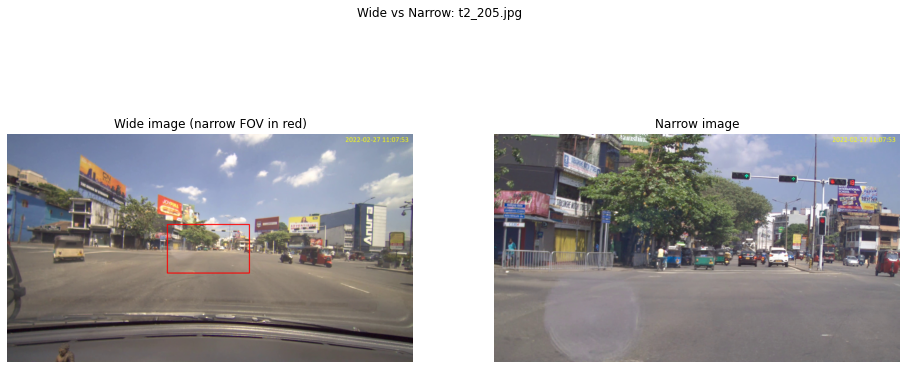

In [70]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

# 경로 설정
wide_dir = "/home/byounggun/ultralytics/traffic_train/wide/images"
narrow_dir = "/home/byounggun/ultralytics/traffic_train/narrow/images"
img_w, img_h = 1920, 1080

# wide/narrow에서 공통 파일명 찾기
wide_files = set([f for f in os.listdir(wide_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
narrow_files = set([f for f in os.listdir(narrow_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
common_files = list(wide_files & narrow_files)
assert len(common_files) > 0, "두 폴더에 공통된 이미지 파일이 없습니다."

# 랜덤 선택
filename = random.choice(common_files)
wide_img_path = os.path.join(wide_dir, filename)
narrow_img_path = os.path.join(narrow_dir, filename)
print(f"선택된 파일: {filename}")

# wide 카메라 파라미터
wide_K = np.array([
    [559.258761, 0, 928.108242],
    [0, 565.348774, 518.787048],
    [0, 0, 1]
])
wide_P = np.array([
    [535.711792, 0, 924.086569, 0],
    [0, 558.997375, 510.222325, 0],
    [0, 0, 1, 0]
])

# narrow 카메라 파라미터
narrow_K = np.array([
    [2651.127798, 0, 819.397071],
    [0, 2635.360938, 896.163803],
    [0, 0, 1]
])
narrow_P = np.array([
    [2407.709780, 0, 801.603047, 0],
    [0, 2544.697607, 897.250521, 0],
    [0, 0, 1, 0]
])

# narrow 이미지의 4개 코너 픽셀을 3D로 투영
narrow_corners = np.array([
    [0, 0],
    [img_w-1, 0],
    [img_w-1, img_h-1],
    [0, img_h-1]
], dtype=np.float32)

narrow_K_inv = np.linalg.inv(narrow_K)
rays = []
for u, v in narrow_corners:
    pixel = np.array([u, v, 1.0])
    ray = narrow_K_inv @ pixel
    ray = ray / ray[2]
    rays.append(ray)
rays = np.stack(rays, axis=0)  # (4, 3)

# wide 카메라로 투영
wide_corners = []
for ray in rays:
    X, Y, Z = ray[0], ray[1], 1.0
    pt3d = np.array([X, Y+0.2, Z, 1.0])
    proj = wide_P @ pt3d
    proj = proj / proj[2]
    wide_corners.append([proj[0], proj[1]])
wide_corners = np.array(wide_corners, dtype=np.int32)

# 이미지 불러오기
wide_img = np.array(Image.open(wide_img_path).convert("RGB"))
narrow_img = np.array(Image.open(narrow_img_path).convert("RGB"))

# wide 이미지에 네모 그리기
img_draw = wide_img.copy()
cv2.polylines(img_draw, [wide_corners.reshape(-1, 1, 2)], isClosed=True, color=(255,0,0), thickness=3)

# 시각화
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.imshow(img_draw)
plt.title("Wide image (narrow FOV in red)")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(narrow_img)
plt.title("Narrow image")
plt.axis('off')
plt.suptitle(f"Wide vs Narrow: {filename}")
plt.show()

In [ ]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# 모델 import (본인 경로에 맞게 수정)
from yolov8_siamese import SiameseYOLOv8s

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(image_path, img_size=640, device='cpu'):
    img = Image.open(image_path).convert("RGB").resize((img_size, img_size))
    img = np.array(img).astype(np.float32) / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)  # (1, 3, H, W)
    return img.to(device)

# feature map 시각화 함수
def show_feature_overlay_with_model(image_path, model, channel=0, alpha=0.5, img_size=640, title=""):
    device = next(model.parameters()).device
    img_tensor = load_and_preprocess_image(image_path, img_size=img_size, device=device)
    with torch.no_grad():
        features = model.extract_backbone_features(img_tensor)
        feat = features[-1].squeeze(0).cpu()  # (C, H, W)
    # 원본 이미지 로드 (시각화용)
    orig = Image.open(image_path).convert("RGB").resize((img_size, img_size))
    orig_np = np.array(orig)
    # feature map (C, H, W) 중 원하는 채널 선택
    fmap = feat[channel]
    fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-8)
    fmap = (fmap * 255).numpy().astype(np.uint8)
    fmap = cv2.resize(fmap, (img_size, img_size))
    heatmap = cv2.applyColorMap(fmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (alpha * heatmap + (1 - alpha) * orig_np).astype(np.uint8)
    # 시각화
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(orig_np)
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title(f"FeatureMap Heatmap (ch {channel})")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f"Overlay (alpha={alpha})")
    plt.axis('off')
    plt.suptitle(title)
    plt.show()

# 모델 준비 (가중치 경로, device 등 본인 환경에 맞게 수정)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseYOLOv8s(yolo_weights_path='yolov8s.pt').to(device)
model.eval()

# wide/narrow 이미지 경로 지정
wide_path = '/home/byounggun/ultralytics/traffic_train/wide/images'
narrow_path = '/home/byounggun/ultralytics/traffic_train/narrow/images'

# wide/narrow 각각 feature map 시각화
show_feature_overlay_with_model(wide_path, model, channel=0, alpha=0.5, img_size=640, title="Wide - Channel 0")
show_feature_overlay_with_model(narrow_path, model, channel=0, alpha=0.5, img_size=640, title="Narrow - Channel 0")

Initializing SiameseYOLOv8s with weights: yolov8s.pt
Successfully extracted backbone and head from yolov8s.pt. NC=80, reg_max=16
[Siamese] Detected backbone output channels: 512


FileNotFoundError: [Errno 2] No such file or directory: 'wide 이미지 경로'